<h3 style="text-align: center; font-family: Arial, sans-serif; color: #4CAF50;">Observations sur les Approches Modélisées</h3>
<ul style="font-family: Arial, sans-serif; font-size: 12pt; color: #333;">
    <li><strong>Observation Unique :</strong>
        <ul style="font-size: 11pt; color: #555;">
            <li>Chaque ligne du dataset (une observation avec ses features) est traitée séparément.</li>
            <li>Le modele n'a pas de notion de dépendance temporelle entre les observations.</li>
        </ul>
    </li>
    <li><strong>Fenêtre Temporelle (non utilisée dans Random Forest classique) :</strong>
        <ul style="font-size: 11pt; color: #555;">
            <li>Les fenêtres temporelles sont couramment utilisées dans des modeles spécifiques aux séries temporelles, comme :</li>
            <ul style="font-size: 11pt; color: #555;">
                <li><strong>LSTM</strong> / <strong>GRU</strong> (réseaux récurrents).</li>
                <li><strong>TFT</strong> (Temporal Fusion Transformer).</li>
                <li><strong>ARIMA, SARIMA, Prophet</strong>, etc.</li>
            </ul>
            <li>Dans ce cas, les observations environnantes sont prises en compte pour capturer les relations temporelles.</li>
        </ul>
    </li>
</ul>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Charger les données
df = pd.read_csv(r"..\..\..\Datasources\MetroPT3_new_imputed_final.csv", delimiter=",", decimal=".", index_col=0)
df.reset_index(drop=True, inplace=True)

In [3]:
display(df.head(3))

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,panne
0,2020-04-12 11:20:00,9.128,8.650,-0.018,-0.022,8.648,55.475,6.0175,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0
1,2020-04-12 11:20:10,9.354,8.896,-0.016,-0.020,8.892,56.525,6.0075,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0
2,2020-04-12 11:20:20,9.548,9.102,-0.016,-0.024,9.098,57.500,5.9725,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0


In [4]:
# Dataset commence le 2020-04-12 11:20:00 et se termine le 2020-07-17 06:00:00
pannes = [
    {'id': 'Panne1',  'start': '2020-04-12 11:50:00', 'end': '2020-04-12 23:30:00'},
    {'id': 'Panne2',  'start': '2020-04-18 00:00:00', 'end': '2020-04-18 23:59:00'},
    {'id': 'Panne3',  'start': '2020-04-19 00:00:00', 'end': '2020-04-19 01:30:00'},
    {'id': 'Panne4',  'start': '2020-04-29 03:20:00', 'end': '2020-04-29 04:00:00'},
    {'id': 'Panne5',  'start': '2020-04-29 22:00:00', 'end': '2020-04-29 22:20:00'},
    {'id': 'Panne6',  'start': '2020-05-13 14:00:00', 'end': '2020-05-13 23:59:00'},
    {'id': 'Panne7',  'start': '2020-05-18 05:00:00', 'end': '2020-05-18 05:30:00'},
    {'id': 'Panne8',  'start': '2020-05-19 10:10:00', 'end': '2020-05-19 11:00:00'},
    {'id': 'Panne9',  'start': '2020-05-19 22:10:00', 'end': '2020-05-19 23:59:00'},
    {'id': 'Panne10', 'start': '2020-05-20 00:00:00', 'end': '2020-05-20 20:00:00'},
    {'id': 'Panne11', 'start': '2020-05-23 09:50:00', 'end': '2020-05-23 10:10:00'},
    {'id': 'Panne12', 'start': '2020-05-29 23:30:00', 'end': '2020-05-29 23:59:00'},
    {'id': 'Panne13', 'start': '2020-05-30 00:00:00', 'end': '2020-05-30 06:00:00'},
    {'id': 'Panne14', 'start': '2020-06-01 15:00:00', 'end': '2020-06-01 15:40:00'},
    {'id': 'Panne15', 'start': '2020-06-03 10:00:00', 'end': '2020-06-03 11:00:00'},
    {'id': 'Panne16', 'start': '2020-06-05 10:00:00', 'end': '2020-06-05 23:59:00'},
    {'id': 'Panne17', 'start': '2020-06-06 00:00:00', 'end': '2020-06-06 23:59:00'},
    {'id': 'Panne18', 'start': '2020-06-07 00:00:00', 'end': '2020-06-07 14:30:00'},
    {'id': 'Panne19', 'start': '2020-07-08 17:30:00', 'end': '2020-07-08 19:00:00'},
    {'id': 'Panne20', 'start': '2020-07-15 14:30:00', 'end': '2020-07-15 19:00:00'},
    {'id': 'Panne21', 'start': '2020-07-17 04:30:00', 'end': '2020-07-17 05:30:00'}
         ]

<h3 style="text-align: center; font-family: Arial, sans-serif; color: RED;">################# DÉCLARATION / INITIALISATION #################</h3>
<ul style="font-family: Arial, sans-serif; font-size: 12pt; color: #333;">
</ul>

In [5]:
# Convertir timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
#display(df.dtypes)

In [6]:
continuous_features = ["TP2","H1","DV_pressure", "Oil_temperature", "Motor_current"]
categorical_features = ["COMP", "DV_eletric", "MPG"]

In [9]:
# Conserver uniquement les colonnes continues, catégorielles et 'timestamp'
columns_to_keep = ["timestamp", "panne"] + continuous_features + categorical_features
df = df[columns_to_keep]

In [10]:
# Convertir les colonnes catégoriques en type category
for col in categorical_features:
    df[col] = df[col].astype("category")


In [11]:
display(df.head(3))

,timestamp,panne,TP2,H1,DV_pressure,Oil_temperature,Motor_current,COMP,DV_eletric,MPG
0,2020-04-12 11:20:00,0,9.128,-0.018,-0.022,55.475,6.0175,0.0,1.0,0.0
1,2020-04-12 11:20:10,0,9.354,-0.016,-0.020,56.525,6.0075,0.0,1.0,0.0
2,2020-04-12 11:20:20,0,9.548,-0.016,-0.024,57.500,5.9725,0.0,1.0,0.0


<h3 style="text-align: center; font-family: Arial, sans-serif; color: RED;">#################### FIN DÉCLARATION #################</h3>
<ul style="font-family: Arial, sans-serif; font-size: 12pt; color: #333;">
</ul>

In [10]:
# Statistiques descriptives globales (exclure les colonnes `_is_missing`)
pd.options.display.float_format = '{:,.2f}'.format

# Statistiques descriptives globales
print("Statistiques descriptives :")
display(df.describe())

# Statistiques pour les colonnes spécifiques (exclure les colonnes `_is_missing`)
# Statistiques pour les colonnes spécifiques
print("\nNombre de valeurs manquantes par colonne :")
missing_counts = df.isnull().sum()
missing_percent = (df.isnull().mean() * 100).map("{:,.2f}%".format)
missing_stats = pd.DataFrame({
    'Valeurs manquantes': missing_counts.map("{:,}".format),
    'Pourcentage manquant': missing_percent
})

# Afficher les statistiques
display(missing_stats)


Statistiques descriptives :


,panne,TP2,H1,DV_pressure,Oil_temperature,Motor_current
count,"827,521.00","827,521.00","827,521.00","827,521.00","827,521.00","827,521.00"
mean,0.06,1.70,7.22,0.11,61.47,2.50
std,0.25,3.17,3.30,0.48,7.40,2.14
min,0.00,-0.03,-0.04,-0.03,19.83,0.02
25%,0.00,-0.01,7.66,-0.02,52.86,0.04
50%,0.00,-0.01,8.38,-0.02,61.90,3.15
75%,0.00,1.39,9.16,0.04,66.95,3.80
max,2.00,10.68,10.29,7.87,89.05,9.27



Nombre de valeurs manquantes par colonne :


,Valeurs manquantes,Pourcentage manquant
timestamp,0,0.00%
panne,0,0.00%
TP2,0,0.00%
H1,0,0.00%
DV_pressure,0,0.00%
Oil_temperature,0,0.00%
Motor_current,0,0.00%
COMP,0,0.00%
DV_eletric,0,0.00%
MPG,0,0.00%


<ul style="font-family: times, serif; font-size:14pt; color:blue;">
<strong>MODELE - Random Forest</strong>
</ul>

<ul style="font-family: times, serif; font-size:14pt; color:RED;">
<strong>TEST 1 : sans fenetre de prediction mais par observation unique</strong>
</ul>

In [11]:
###################################################################
################ Train : Panne1  to Panne14        ################
################ Test  : Panne15 to Panne21        ################
###################################################################


# Définir les limites pour le train et le test
train_start = pd.Timestamp('2020-04-12 11:20:00')
train_end   = pd.Timestamp('2020-06-01 15:40:00')
test_start  = pd.Timestamp('2020-06-01 15:40:10')  # Observation suivante
test_end    = pd.Timestamp('2020-07-17 06:00:00')

# Filtrer les indices pour le train et le test
train_indices = df[(df['timestamp'] >= train_start) & (df['timestamp'] <= train_end)].index
test_indices  = df[(df['timestamp'] >= test_start) & (df['timestamp'] <= test_end)].index

# Créer les ensembles d'entrainement et de test
X_train = df.loc[train_indices, continuous_features + categorical_features]
y_train = df.loc[train_indices, 'panne']

X_test = df.loc[test_indices, continuous_features + categorical_features]
y_test = df.loc[test_indices, 'panne']

# Vérifications des tailles des ensembles
print(f"Taille de l'ensemble d'entrainement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")
print(f"Pannes dans l'entrainement : {y_train.sum()} ({y_train.mean():.2%})")
print(f"Pannes dans le test : {y_test.sum()} ({y_test.mean():.2%})")


Taille de l'ensemble d'entrainement : 433561
Taille de l'ensemble de test : 393960
Pannes dans l'entrainement : 30380 (7.01%)
Pannes dans le test : 22695 (5.76%)


In [12]:
# Entrainer le modele Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Entrainement du modele
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Évaluation sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

# Importance des features
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importance des features :")
print(feature_importances)

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    371725
           1       0.93      0.86      0.89     21775
           2       0.02      0.00      0.00       460

    accuracy                           0.99    393960
   macro avg       0.65      0.62      0.63    393960
weighted avg       0.99      0.99      0.99    393960

Importance des features :
           Feature  Importance
2      DV_pressure        0.45
3  Oil_temperature        0.24
1               H1        0.10
0              TP2        0.10
4    Motor_current        0.10
5             COMP        0.01
6       DV_eletric        0.00
7              MPG        0.00


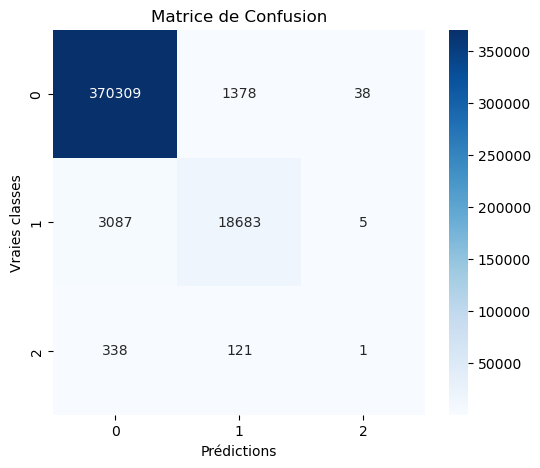

In [13]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

<ul style="font-family: times, serif; font-size:14pt; color:RED;">
<strong>TEST 2 : sans fenetre de prediction mais par observation unique</strong>
</ul>

In [14]:
###################################################################
################ Train : Panne1  to Panne18        ################
################ Test  : Panne19 to Panne21        ################
###################################################################

# Définir les périodes pour le train et le test
train_periods = [{'start': '2020-04-12 11:20:00', 'end': '2020-06-07 14:30:00'}]

test_periods  = [{'start': '2020-06-07 14:30:10', 'end': '2020-07-17 06:00:00'}]

# Filtrer les indices pour le train
train_indices = []
for period in train_periods:
    start = pd.Timestamp(period['start'])
    end = pd.Timestamp(period['end'])
    train_indices.extend(df[(df['timestamp'] >= start) & (df['timestamp'] <= end)].index.tolist())

# Filtrer les indices pour le test
test_indices = []
for period in test_periods:
    start = pd.Timestamp(period['start'])
    end = pd.Timestamp(period['end'])
    test_indices.extend(df[(df['timestamp'] >= start) & (df['timestamp'] <= end)].index.tolist())

# Vérifier qu'il n'y a pas de chevauchement entre train et test
assert len(set(train_indices).intersection(set(test_indices))) == 0, "Les ensembles d'entrainement et de test se chevauchent !"

# Créer les ensembles d'entrainement et de test
X_train = df.loc[train_indices, continuous_features + categorical_features]
y_train = df.loc[train_indices, 'panne']

X_test = df.loc[test_indices, continuous_features + categorical_features]
y_test = df.loc[test_indices, 'panne']

# Vérifications des tailles des ensembles
print(f"Taille de l'ensemble d'entrainement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")
print(f"Pannes dans l'entrainement : {y_train.sum()} ({y_train.mean():.2%})")
print(f"Pannes dans le test : {y_test.sum()} ({y_test.mean():.2%})")


Taille de l'ensemble d'entrainement : 484981
Taille de l'ensemble de test : 342540
Pannes dans l'entrainement : 50012 (10.31%)
Pannes dans le test : 3063 (0.89%)


In [15]:
# Entrainer le modele Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Entrainement du modele
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Évaluation sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

# Importance des features
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importance des features :")
print(feature_importances)

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    339747
           1       0.59      0.62      0.61      2523
           2       0.00      0.00      0.00       270

    accuracy                           0.99    342540
   macro avg       0.53      0.54      0.53    342540
weighted avg       0.99      0.99      0.99    342540

Importance des features :
           Feature  Importance
2      DV_pressure        0.43
3  Oil_temperature        0.22
1               H1        0.12
0              TP2        0.11
4    Motor_current        0.10
5             COMP        0.01
6       DV_eletric        0.01
7              MPG        0.00


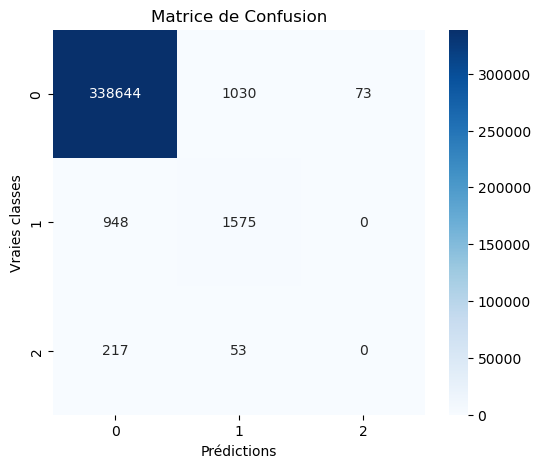

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

<ul style="font-family: times, serif; font-size:14pt; color:RED;">
<strong>TEST 3 : sans fenetre de prediction mais par observation unique</strong>
</ul>

In [17]:
###################################################################
################ Train : Panne14  to Panne21        ###############
################ Test  : Panne1   to Panne13        ###############
###################################################################

# Définir les périodes pour le train et le test
train_periods = [{'start': '2020-06-01 15:00:00', 'end': '2020-07-17 06:00:00'}]

test_periods  = [{'start': '2020-04-12 11:20:00', 'end': '2020-06-01 14:59:50'}]

# Filtrer les indices pour le train
train_indices = []
for period in train_periods:
    start = pd.Timestamp(period['start'])
    end = pd.Timestamp(period['end'])
    train_indices.extend(df[(df['timestamp'] >= start) & (df['timestamp'] <= end)].index.tolist())

# Filtrer les indices pour le test
test_indices = []
for period in test_periods:
    start = pd.Timestamp(period['start'])
    end = pd.Timestamp(period['end'])
    test_indices.extend(df[(df['timestamp'] >= start) & (df['timestamp'] <= end)].index.tolist())

# Vérifier qu'il n'y a pas de chevauchement entre train et test
assert len(set(train_indices).intersection(set(test_indices))) == 0, "Les ensembles d'entrainement et de test se chevauchent !"

# Créer les ensembles d'entrainement et de test
X_train = df.loc[train_indices, continuous_features + categorical_features]
y_train = df.loc[train_indices, 'panne']

X_test = df.loc[test_indices, continuous_features + categorical_features]
y_test = df.loc[test_indices, 'panne']

# Vérifications des tailles des ensembles
print(f"Taille de l'ensemble d'entrainement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")
print(f"Pannes dans l'entrainement : {y_train.sum()} ({y_train.mean():.2%})")
print(f"Pannes dans le test : {y_test.sum()} ({y_test.mean():.2%})")


Taille de l'ensemble d'entrainement : 394201
Taille de l'ensemble de test : 433320
Pannes dans l'entrainement : 22936 (5.82%)
Pannes dans le test : 30139 (6.96%)


In [18]:
# Entrainer le modele Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Entrainement du modele
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Évaluation sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

# Importance des features
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importance des features :")
print(feature_importances)

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    404186
           1       0.96      0.85      0.90     28129
           2       0.26      0.04      0.08      1005

    accuracy                           0.99    433320
   macro avg       0.74      0.63      0.66    433320
weighted avg       0.98      0.99      0.98    433320

Importance des features :
           Feature  Importance
2      DV_pressure        0.43
3  Oil_temperature        0.29
0              TP2        0.09
1               H1        0.09
4    Motor_current        0.08
6       DV_eletric        0.01
5             COMP        0.01
7              MPG        0.00


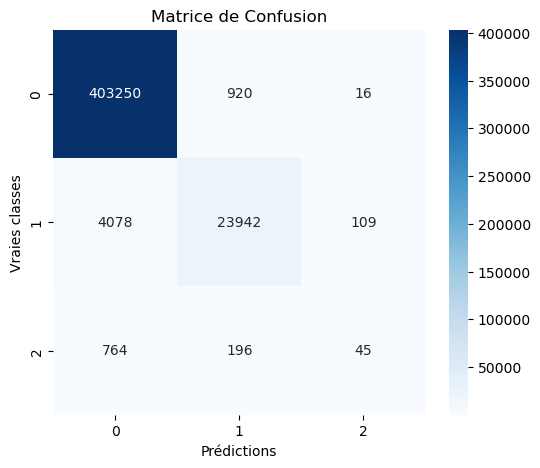

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

<ul style="font-family: times, serif; font-size:14pt; color:RED;">
<strong>TEST 4 : sans fenetre de prediction mais par observation unique</strong>
</ul>

In [20]:
###################################################################
################ Train : Pannes mixées par altérnance     #########
################ Test  : Pannes mixées par altérnance     #########
###################################################################

#  ensembles train et test en alternant les périodes de pannes. Cela garantira que chaque période appartient soit 
# à l’ensemble de train soit à celui de test, sans chevauchement. 


# Définir les périodes pour le train et le test
train_periods = [
    {'start': '2020-04-12 11:20:00', 'end': '2020-04-12 23:30:00'},  # Panne1
    {'start': '2020-04-18 23:59:10', 'end': '2020-04-19 01:30:00'},  # Panne3
    {'start': '2020-04-29 04:00:10', 'end': '2020-04-29 22:00:00'},  # Panne5
    {'start': '2020-05-13 23:59:10', 'end': '2020-05-18 05:00:00'},  # Panne7
    {'start': '2020-05-19 11:00:10', 'end': '2020-05-19 22:10:00'},  # Panne9
    {'start': '2020-05-20 20:00:10', 'end': '2020-05-23 09:50:00'},  # Panne11
    {'start': '2020-05-30 06:00:10', 'end': '2020-06-01 15:00:00'},  # Panne13
    {'start': '2020-06-03 11:00:10', 'end': '2020-06-05 10:00:00'},  # Panne15
    {'start': '2020-06-07 14:30:10', 'end': '2020-07-08 17:30:00'},  # Panne19
    {'start': '2020-07-15 19:00:10', 'end': '2020-07-17 06:00:00'}   # Panne21
]

test_periods = [
    {'start': '2020-04-12 23:30:10', 'end': '2020-04-18 23:59:00'},  # Panne2
    {'start': '2020-04-19 01:30:10', 'end': '2020-04-29 03:20:00'},  # Panne4
    {'start': '2020-04-29 22:20:10', 'end': '2020-05-13 14:00:00'},  # Panne6
    {'start': '2020-05-18 05:30:10', 'end': '2020-05-19 10:10:00'},  # Panne8
    {'start': '2020-05-19 23:59:10', 'end': '2020-05-20 00:00:00'},  # Panne10
    {'start': '2020-05-23 10:10:10', 'end': '2020-05-29 23:30:00'},  # Panne12
    {'start': '2020-06-01 15:40:10', 'end': '2020-06-03 10:00:00'},  # Panne14
    {'start': '2020-06-05 23:59:10', 'end': '2020-06-07 00:00:00'},  # Panne16
    {'start': '2020-07-08 19:00:10', 'end': '2020-07-15 14:30:00'}   # Panne20
]

# Filtrer les indices pour le train
train_indices = []
for period in train_periods:
    start = pd.Timestamp(period['start'])
    end = pd.Timestamp(period['end'])
    train_indices.extend(df[(df['timestamp'] >= start) & (df['timestamp'] <= end)].index.tolist())

# Filtrer les indices pour le test
test_indices = []
for period in test_periods:
    start = pd.Timestamp(period['start'])
    end = pd.Timestamp(period['end'])
    test_indices.extend(df[(df['timestamp'] >= start) & (df['timestamp'] <= end)].index.tolist())

# Vérifier qu'il n'y a pas de chevauchement entre train et test
assert len(set(train_indices).intersection(set(test_indices))) == 0, "Les ensembles d'entrainement et de test se chevauchent !"

# Créer les ensembles d'entrainement et de test
X_train = df.loc[train_indices, continuous_features + categorical_features]
y_train = df.loc[train_indices, 'panne']

X_test = df.loc[test_indices, continuous_features + categorical_features]
y_test = df.loc[test_indices, 'panne']

# Vérifications des tailles des ensembles
print(f"Taille de l'ensemble d'entrainement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")
print(f"Pannes dans l'entrainement : {y_train.sum()} ({y_train.mean():.2%})")
print(f"Pannes dans le test : {y_test.sum()} ({y_test.mean():.2%})")

Taille de l'ensemble d'entrainement : 393013
Taille de l'ensemble de test : 406746
Pannes dans l'entrainement : 6740 (1.71%)
Pannes dans le test : 18568 (4.57%)


In [21]:
# Entrainer le modele Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Entrainement du modele
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Évaluation sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

# Importance des features
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importance des features :")
print(feature_importances)

Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    388823
           1       0.97      0.51      0.67     17278
           2       0.09      0.10      0.10       645

    accuracy                           0.98    406746
   macro avg       0.68      0.54      0.59    406746
weighted avg       0.98      0.98      0.97    406746

Importance des features :
           Feature  Importance
2      DV_pressure        0.48
3  Oil_temperature        0.23
0              TP2        0.10
1               H1        0.09
4    Motor_current        0.07
6       DV_eletric        0.01
7              MPG        0.01
5             COMP        0.01


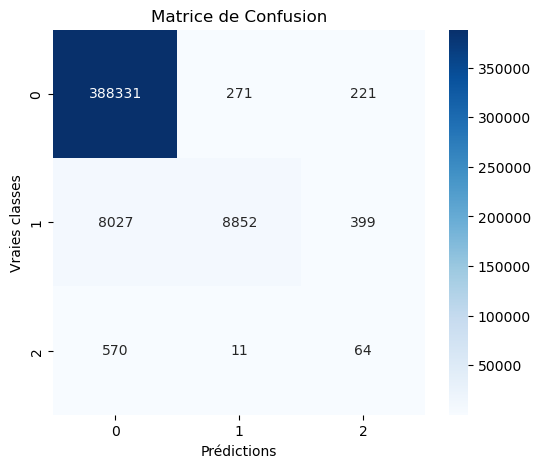

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

<ul style="font-family: times, serif; font-size:14pt; color:RED;">
<strong>TEST 5 : sans fenetre de prediction mais par observation unique</strong>
</ul>

In [23]:
###################################################################
################ Train : Pannes mixées par altérnance     #########
################ Test  : Pannes mixées par altérnance     #########
###################################################################

# Définir les périodes pour le train et le test

train_periods = [
    {'start': '2020-04-12 23:30:10', 'end': '2020-04-18 23:59:00'},  # Panne2
    {'start': '2020-04-19 01:30:10', 'end': '2020-04-29 03:20:00'},  # Panne4
    {'start': '2020-04-29 22:20:10', 'end': '2020-05-13 14:00:00'},  # Panne6
    {'start': '2020-05-18 05:30:10', 'end': '2020-05-19 10:10:00'},  # Panne8
    {'start': '2020-05-19 23:59:10', 'end': '2020-05-20 00:00:00'},  # Panne10
    {'start': '2020-05-23 10:10:10', 'end': '2020-05-29 23:30:00'},  # Panne12
    {'start': '2020-06-01 15:40:10', 'end': '2020-06-03 10:00:00'},  # Panne14
    {'start': '2020-06-05 23:59:10', 'end': '2020-06-07 00:00:00'},  # Panne16
    {'start': '2020-07-08 19:00:10', 'end': '2020-07-15 14:30:00'}   # Panne20
]

test_periods = [
    {'start': '2020-04-12 11:20:00', 'end': '2020-04-12 23:30:00'},  # Panne1
    {'start': '2020-04-18 23:59:10', 'end': '2020-04-19 01:30:00'},  # Panne3
    {'start': '2020-04-29 04:00:10', 'end': '2020-04-29 22:00:00'},  # Panne5
    {'start': '2020-05-13 23:59:10', 'end': '2020-05-18 05:00:00'},  # Panne7
    {'start': '2020-05-19 11:00:10', 'end': '2020-05-19 22:10:00'},  # Panne9
    {'start': '2020-05-20 20:00:10', 'end': '2020-05-23 09:50:00'},  # Panne11
    {'start': '2020-05-30 06:00:10', 'end': '2020-06-01 15:00:00'},  # Panne13
    {'start': '2020-06-03 11:00:10', 'end': '2020-06-05 10:00:00'},  # Panne15
    {'start': '2020-06-07 14:30:10', 'end': '2020-07-08 17:30:00'},  # Panne19
    {'start': '2020-07-15 19:00:10', 'end': '2020-07-17 06:00:00'}   # Panne21
]

# Filtrer les indices pour le train
train_indices = []
for period in train_periods:
    start = pd.Timestamp(period['start'])
    end = pd.Timestamp(period['end'])
    train_indices.extend(df[(df['timestamp'] >= start) & (df['timestamp'] <= end)].index.tolist())

# Filtrer les indices pour le test
test_indices = []
for period in test_periods:
    start = pd.Timestamp(period['start'])
    end = pd.Timestamp(period['end'])
    test_indices.extend(df[(df['timestamp'] >= start) & (df['timestamp'] <= end)].index.tolist())

# Vérifier qu'il n'y a pas de chevauchement entre train et test
assert len(set(train_indices).intersection(set(test_indices))) == 0, "Les ensembles d'entrainement et de test se chevauchent !"

# Créer les ensembles d'entrainement et de test
X_train = df.loc[train_indices, continuous_features + categorical_features]
y_train = df.loc[train_indices, 'panne']

X_test = df.loc[test_indices, continuous_features + categorical_features]
y_test = df.loc[test_indices, 'panne']

# Vérifications des tailles des ensembles
print(f"Taille de l'ensemble d'entrainement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")
print(f"Pannes dans l'entrainement : {y_train.sum()} ({y_train.mean():.2%})")
print(f"Pannes dans le test : {y_test.sum()} ({y_test.mean():.2%})")

Taille de l'ensemble d'entrainement : 406746
Taille de l'ensemble de test : 393013
Pannes dans l'entrainement : 18568 (4.57%)
Pannes dans le test : 6740 (1.71%)


In [24]:
# Entrainer le modele Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Entrainement du modele
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Évaluation sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

# Importance des features
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importance des features :")
print(feature_importances)

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    387088
           1       0.73      0.30      0.43      5110
           2       0.04      0.02      0.03       815

    accuracy                           0.99    393013
   macro avg       0.59      0.44      0.48    393013
weighted avg       0.98      0.99      0.98    393013

Importance des features :
           Feature  Importance
2      DV_pressure        0.46
3  Oil_temperature        0.20
1               H1        0.12
0              TP2        0.10
4    Motor_current        0.09
5             COMP        0.02
6       DV_eletric        0.01
7              MPG        0.01


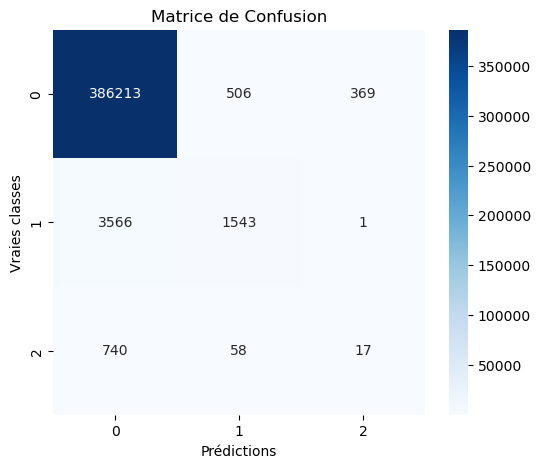

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

<ul style="font-family: times, serif; font-size:14pt; color:RED;">
<strong>TEST 6 : FENETRES DE 15 MIN<strong>
</ul>

In [12]:
# DEFINIR LE FENETRAGE

## window_size =  15 mn  ==> 90   Observations
## window_size =  30 mn  ==> 180  Observations
## window_size =  60 mn  ==> 360  Observations

window_size = 90 

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings

# Masquer les warnings spécifiques aux performances de DataFrame fragmenté
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


df_updated =df.copy()

# Créer une fenêtre temporelle
def create_temporal_window(df_entree, features, window_size):
    df_windowed = df_entree.copy()
    for lag in range(1, window_size):
        for feature in features:
            df_windowed[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    
    # Supprimer les lignes affectées par les décalages
    df_windowed = df_windowed.iloc[window_size - 1:].reset_index(drop=True)
    return df_windowed

# Taille de la fenêtre (90 observations)
window_size = 90

# Appliquer la création de fenêtres temporelles
df_windowed = create_temporal_window(df_updated, continuous_features, window_size)

# Vérification des dimensions
print(f"Taille originale : {df.shape}")
print(f"Taille avec fenêtres temporelles : {df_windowed.shape}")


Taille originale : (827521, 10)
Taille avec fenêtres temporelles : (827432, 455)


In [13]:
display(df_windowed.head(2))

,timestamp,panne,TP2,H1,DV_pressure,Oil_temperature,Motor_current,COMP,DV_eletric,MPG,...,TP2_lag_88,H1_lag_88,DV_pressure_lag_88,Oil_temperature_lag_88,Motor_current_lag_88,TP2_lag_89,H1_lag_89,DV_pressure_lag_89,Oil_temperature_lag_89,Motor_current_lag_89
0,2020-04-12 11:34:50,0,-0.014,9.220,-0.022,59.550,0.0425,1.0,0.0,1.0,...,9.354,-0.016,-0.020,56.525,6.0075,9.128,-0.018,-0.022,55.475,6.0175
1,2020-04-12 11:35:00,2,-0.014,9.206,-0.022,59.475,0.0400,1.0,0.0,1.0,...,9.548,-0.016,-0.024,57.500,5.9725,9.354,-0.016,-0.020,56.525,6.0075


In [27]:
###################################################################
################ Train : Panne14  to Panne21        ###############
################ Test  : Panne1   to Panne13        ###############
###################################################################


# Définir les périodes pour le train et le test
train_periods = [{'start': '2020-06-01 15:00:00', 'end': '2020-07-17 06:00:00'}]

test_periods  = [{'start': '2020-04-12 11:20:00', 'end': '2020-06-01 14:59:50'}]

# Affectations pour les périodes d'entrainement
start_train = pd.Timestamp(train_periods[0]['start'])
end_train = pd.Timestamp(train_periods[0]['end'])
train_indices = df_windowed[(df_windowed['timestamp'] >= start_train) & (df_windowed['timestamp'] <= end_train)].index.tolist()

# Affectations pour les périodes de test
start_test = pd.Timestamp(test_periods[0]['start'])
end_test = pd.Timestamp(test_periods[0]['end'])
test_indices = df_windowed[(df_windowed['timestamp'] >= start_test) & (df_windowed['timestamp'] <= end_test)].index.tolist()

# Créer les ensembles d'entrainement et de test
X_train = df_windowed.loc[train_indices].drop(columns=['timestamp', 'panne'])
y_train = df_windowed.loc[train_indices, 'panne']

X_test = df_windowed.loc[test_indices].drop(columns=['timestamp', 'panne'])
y_test = df_windowed.loc[test_indices, 'panne']

# Vérification des tailles
print(f"Taille de l'ensemble d'entrainement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")


Taille de l'ensemble d'entrainement : 394201
Taille de l'ensemble de test : 433231


In [28]:
# Entrainer le modele Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Évaluation sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

# Importance des features
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importance des features :")
print(feature_importances)


Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    404097
           1       0.96      0.80      0.87     28129
           2       0.34      0.05      0.09      1005

    accuracy                           0.98    433231
   macro avg       0.76      0.62      0.65    433231
weighted avg       0.98      0.98      0.98    433231

Importance des features :
                Feature  Importance
45    DV_pressure_lag_8        0.06
50    DV_pressure_lag_9        0.05
15    DV_pressure_lag_2        0.04
55   DV_pressure_lag_10        0.03
100  DV_pressure_lag_19        0.03
..                  ...         ...
295  DV_pressure_lag_58        0.00
265  DV_pressure_lag_52        0.00
285  DV_pressure_lag_56        0.00
330  DV_pressure_lag_65        0.00
245  DV_pressure_lag_48        0.00

[453 rows x 2 columns]


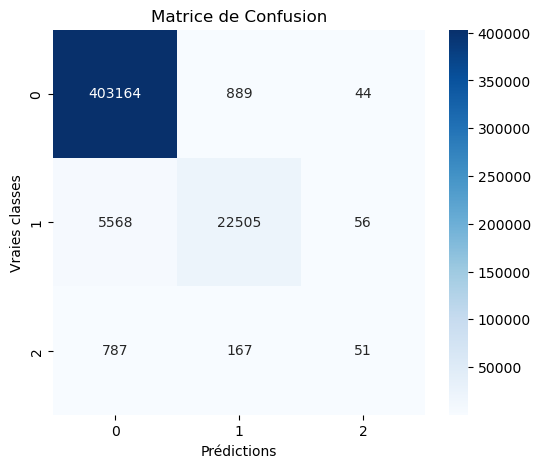

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

In [30]:
###################################################################
################ Train : Panne1  to Panne14        ################
################ Test  : Panne15 to Panne21        ################
###################################################################


# Définir les limites pour le train et le test
train_periods = [{'start': '2020-04-12 11:20:00','end': '2020-06-01 15:40:00'}]
test_periods  = [{'start': '2020-06-01 15:40:10','end': '2020-07-17 06:00:00'}]

# Affectations pour les périodes d'entrainement
start_train = pd.Timestamp(train_periods[0]['start'])
end_train = pd.Timestamp(train_periods[0]['end'])
train_indices = df_windowed[(df_windowed['timestamp'] >= start_train) & (df_windowed['timestamp'] <= end_train)].index.tolist()

# Affectations pour les périodes de test
start_test = pd.Timestamp(test_periods[0]['start'])
end_test = pd.Timestamp(test_periods[0]['end'])
test_indices = df_windowed[(df_windowed['timestamp'] >= start_test) & (df_windowed['timestamp'] <= end_test)].index.tolist()

# Créer les ensembles d'entrainement et de test
X_train = df_windowed.loc[train_indices].drop(columns=['timestamp', 'panne'])
y_train = df_windowed.loc[train_indices, 'panne']

X_test = df_windowed.loc[test_indices].drop(columns=['timestamp', 'panne'])
y_test = df_windowed.loc[test_indices, 'panne']

# Vérification des tailles
print(f"Taille de l'ensemble d'entrainement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")


Taille de l'ensemble d'entrainement : 433472
Taille de l'ensemble de test : 393960


In [31]:
# Entrainer le modele Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Évaluation sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

# Importance des features
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importance des features :")
print(feature_importances)


Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    371725
           1       0.96      0.80      0.88     21775
           2       0.06      0.01      0.02       460

    accuracy                           0.99    393960
   macro avg       0.67      0.60      0.63    393960
weighted avg       0.99      0.99      0.99    393960

Importance des features :
                  Feature  Importance
45      DV_pressure_lag_8        0.06
15      DV_pressure_lag_2        0.05
50      DV_pressure_lag_9        0.05
25      DV_pressure_lag_4        0.05
90     DV_pressure_lag_17        0.04
..                    ...         ...
178            TP2_lag_35        0.00
142  Motor_current_lag_27        0.00
308            TP2_lag_61        0.00
168            TP2_lag_33        0.00
112  Motor_current_lag_21        0.00

[453 rows x 2 columns]


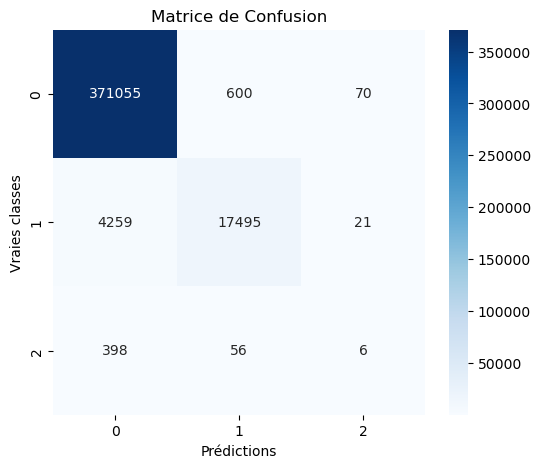

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()